# Uncertainty Prediction and Model Explainability

This module extends the forecasting pipeline with three objectives:
1. Estimate prediction uncertainty (via quantile regression and/or bootstrap ensembling)
2. Explain model behavior using SHAP and error analysis
3. Prepare business visualization outputs using tools like Tableau, Power BI, or Streamlit

Components implemented:
- Quantile regression with LightGBM to output prediction intervals
- SHAP (SHapley Additive exPlanations) values for feature importance
- Top-N item/store level error breakdown to identify unstable segments
- Export-ready summary data for BI dashboards:
    - Predicted trends, confidence intervals
    - Inventory alert flags
    - RMSE, MAE, WAPE accuracy metrics
    - Business recommendations (e.g., pre-replenish Item A in Store Y)

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load preprocessed tabular data
print("Loading preprocessed feature data...")
df = pd.read_pickle("/Users/nanxuan/Desktop/M5 Enhanced Forecasting System/Dataset/processed_sales_data.pkl")
df.dropna(subset=["sales_lag_7", "rolling_mean_7", "price_change"], inplace=True)

Loading preprocessed feature data...


In [3]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Feature selection
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
            'day_of_week', 'month', 'year', 'is_weekend', 'is_us_holiday',
            'sales_lag_7', 'rolling_mean_7', 'price_change']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

X = df[features]
y = df['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# LightGBM quantile models
print("Training LightGBM quantile regression models...")
quantiles = [0.1, 0.5, 0.9]
models = {}
for q in quantiles:
    print(f"Training for quantile {q}")
    params = {
        'objective': 'quantile',
        'alpha': q,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbosity': -1,
        'metric': 'quantile'
    }
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=200,
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(period=50)
        ]
    )
    models[q] = model


Training LightGBM quantile regression models...
Training for quantile 0.1
Training until validation scores don't improve for 20 rounds
[50]	valid_0's quantile: 0.138438
[100]	valid_0's quantile: 0.138049
[150]	valid_0's quantile: 0.138034
[200]	valid_0's quantile: 0.138033
Did not meet early stopping. Best iteration is:
[200]	valid_0's quantile: 0.138033
Training for quantile 0.5
Training until validation scores don't improve for 20 rounds
[50]	valid_0's quantile: 0.481859
[100]	valid_0's quantile: 0.471311
[150]	valid_0's quantile: 0.47006
[200]	valid_0's quantile: 0.469629
Did not meet early stopping. Best iteration is:
[200]	valid_0's quantile: 0.469629
Training for quantile 0.9
Training until validation scores don't improve for 20 rounds
[50]	valid_0's quantile: 0.32894
[100]	valid_0's quantile: 0.320307
[150]	valid_0's quantile: 0.319387
[200]	valid_0's quantile: 0.319257
Did not meet early stopping. Best iteration is:
[200]	valid_0's quantile: 0.319257


In [6]:
# Predict quantiles on validation set
print("Generating prediction intervals on validation set...")
pred_10 = models[0.1].predict(X_val)
pred_50 = models[0.5].predict(X_val)
pred_90 = models[0.9].predict(X_val)


Generating prediction intervals on validation set...


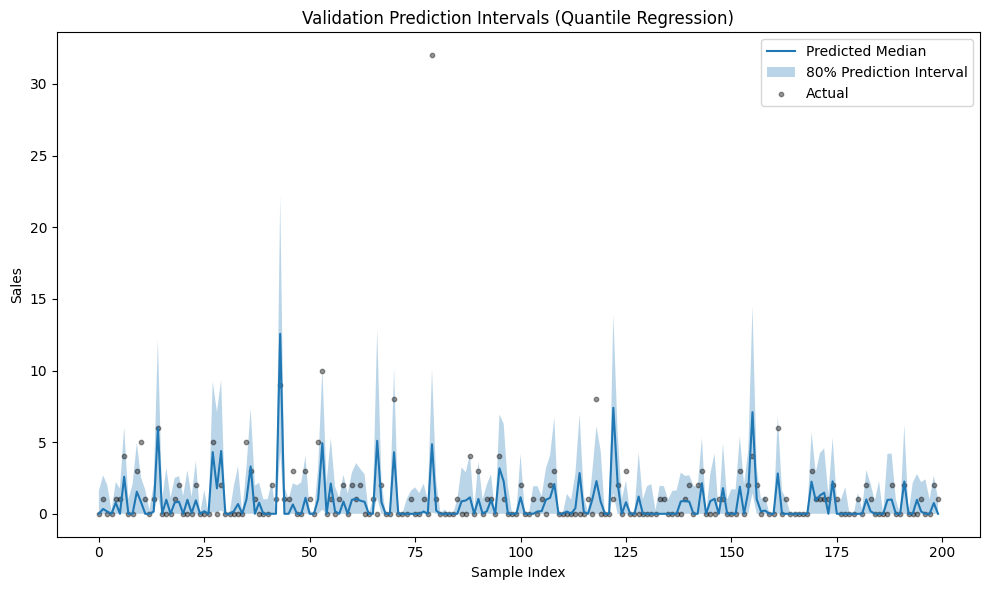

In [7]:
# Plot uncertainty band
plt.figure(figsize=(10, 6))
idx = np.random.choice(len(y_val), 200, replace=False)
sns.lineplot(x=np.arange(len(idx)), y=pred_50[idx], label='Predicted Median')
plt.fill_between(np.arange(len(idx)), pred_10[idx], pred_90[idx], alpha=0.3, label='80% Prediction Interval')
plt.scatter(np.arange(len(idx)), y_val.values[idx], s=10, color='black', alpha=0.4, label='Actual')
plt.legend()
plt.title("Validation Prediction Intervals (Quantile Regression)")
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.tight_layout()
plt.savefig("quantile_prediction_intervals.png")
plt.show()

In [9]:
# SHAP Explainability for median model
print("Computing SHAP values for feature explainability...")
import shap
explainer = shap.TreeExplainer(models[0.5])
shap_values = explainer.shap_values(X_val)

Computing SHAP values for feature explainability...


/Users/nanxuan/miniconda3/envs/m5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


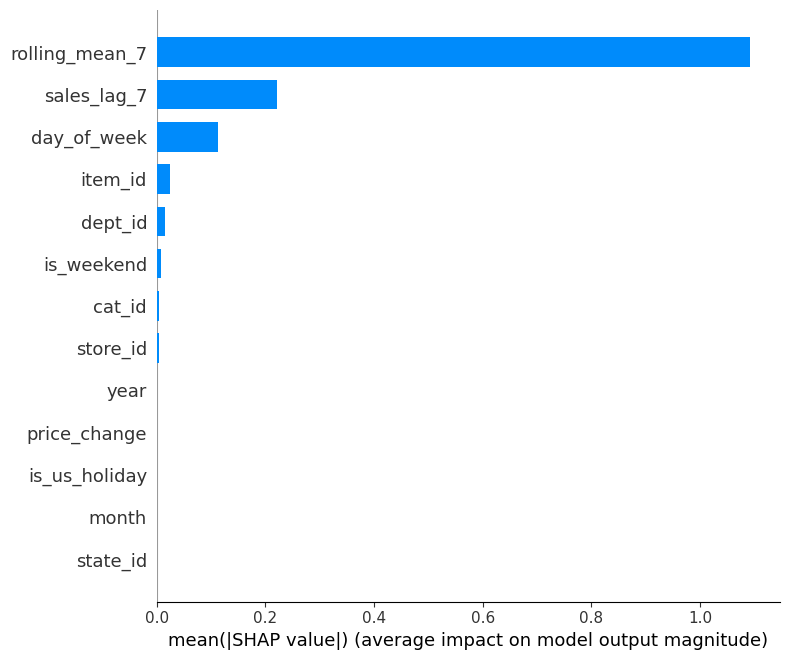

In [10]:
# Plot summary
plt.title("SHAP Summary Plot (Median Quantile Model)")
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("shap_summary_median_model.png")
plt.show()

In [11]:
# Top-N item/store error analysis
print("Performing Top-N error analysis for items and stores...")
val_df = X_val.copy()
val_df['actual'] = y_val.values
val_df['pred_50'] = pred_50
val_df['abs_error'] = np.abs(val_df['actual'] - val_df['pred_50'])

Performing Top-N error analysis for items and stores...


In [12]:
# Aggregate error per item_id
item_errors = val_df.groupby('item_id')['abs_error'].mean().sort_values(ascending=False).head(10)
store_errors = val_df.groupby('store_id')['abs_error'].mean().sort_values(ascending=False).head(10)


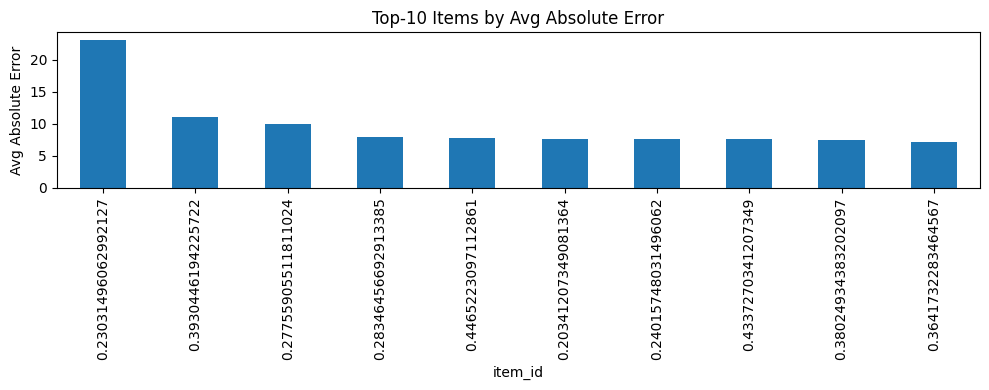

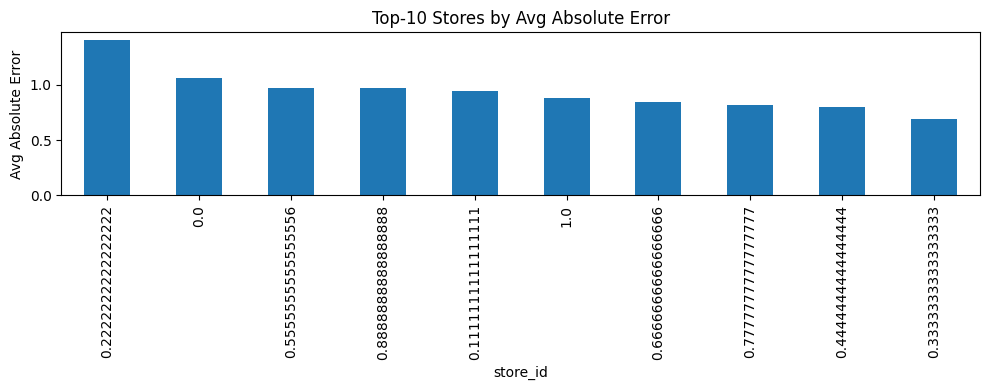

In [13]:
# Plot
plt.figure(figsize=(10, 4))
item_errors.plot(kind='bar', title='Top-10 Items by Avg Absolute Error')
plt.ylabel("Avg Absolute Error")
plt.tight_layout()
plt.savefig("top10_item_errors.png")
plt.show()

plt.figure(figsize=(10, 4))
store_errors.plot(kind='bar', title='Top-10 Stores by Avg Absolute Error')
plt.ylabel("Avg Absolute Error")
plt.tight_layout()
plt.savefig("top10_store_errors.png")
plt.show()

In [14]:
# Top-N item/store error analysis
print("Performing Top-N error analysis for items and stores...")
val_df = X_val.copy()
val_df['actual'] = y_val.values
val_df['pred_10'] = pred_10
val_df['pred_50'] = pred_50
val_df['pred_90'] = pred_90
val_df['abs_error'] = np.abs(val_df['actual'] - val_df['pred_50'])
val_df['overstock_flag'] = (val_df['actual'] < val_df['pred_10']).astype(int)
val_df['understock_flag'] = (val_df['actual'] > val_df['pred_90']).astype(int)

Performing Top-N error analysis for items and stores...


In [15]:
# Compute metrics
from sklearn.metrics import mean_absolute_error
rmse = np.sqrt(np.mean((val_df['actual'] - val_df['pred_50'])**2))
mae = mean_absolute_error(val_df['actual'], val_df['pred_50'])
wape = np.sum(np.abs(val_df['actual'] - val_df['pred_50'])) / np.sum(np.abs(val_df['actual']))


In [16]:
# Save BI-ready summary file
summary_df = val_df.copy()
summary_df['rmse'] = rmse
summary_df['mae'] = mae
summary_df['wape'] = wape
summary_df.to_csv("bi_dashboard_summary.csv", index=False)
print("Exported BI summary data to bi_dashboard_summary.csv")

Exported BI summary data to bi_dashboard_summary.csv
